In [1]:
# Cell 1: Imports and Setup
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import os


In [2]:
# Cell 2: Load and Preprocess Data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape and normalize
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255
input_shape = (28, 28, 1)

# One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [3]:
# ✅ Data Augmentation for Training
datagen = ImageDataGenerator(
    rotation_range=10,      # Random rotation between -10 to 10 degrees
    zoom_range=0.1,        # Random zoom
    width_shift_range=0.1,  # Horizontal shift
    height_shift_range=0.1, # Vertical shift
    shear_range=0.1        # Shear transformation
)

In [4]:
# ✅ Data Preprocessing for Validation (No Augmentation)
val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow(x_test, y_test, batch_size=128, shuffle=False)

In [5]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),  # Increased Dropout

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # Added L2 Regularization
    Dropout(0.5),
    Dense(10, activation='softmax')
])

e:\jupiter\deep_learning\keras_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,199,882 (4.58 MB)

 Trainable params: 1,199,882 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

# Training Parameters
batch_size = 128
epochs = 20  # Early stopping will prevent overfitting

In [8]:
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),  # Augmented Training Data
    epochs=epochs,
    validation_data=val_generator,  # Fixed Validation Data
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/20


e:\jupiter\deep_learning\keras_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 89ms/step - accuracy: 0.7139 - loss: 1.0474 - val_accuracy: 0.9795 - val_loss: 0.2545 - learning_rate: 0.0010
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 30s 64ms/step - accuracy: 0.9197 - loss: 0.4557 - val_accuracy: 0.9859 - val_loss: 0.2332 - learning_rate: 0.0010
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - accuracy: 0.9329 - loss: 0.4081 - val_accuracy: 0.9860 - val_loss: 0.2280 - learning_rate: 0.0010
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 54s 115ms/step - accuracy: 0.9420 - loss: 0.3786 - val_accuracy: 0.9877 - val_loss: 0.2263 - learning_rate: 0.0010
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 57s 122ms/step - accuracy: 0.9425 - loss: 0.3740 - val_accuracy: 0.9886 - val_loss: 0.2202 - learning_rate: 0.0010
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 56s 120ms/step - accuracy: 0.9505 - loss: 0.3475 - val_accuracy: 0.9884 - val_loss: 0.2167 - learning_rate: 0.0010
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 89ms/step - accuracy: 0.9512 - loss: 0.3

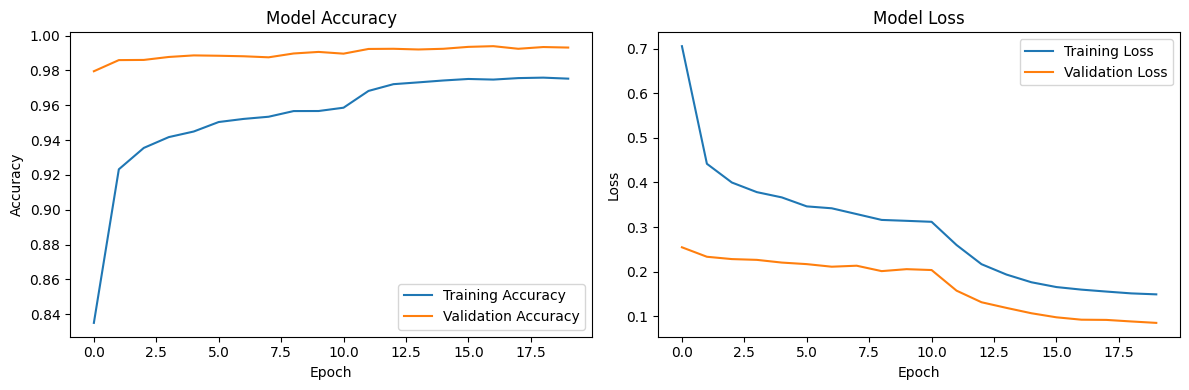

In [9]:

# Plot Results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
if not os.path.exists('models'):
    os.makedirs('models')

model.save('models/improved_mnist_model.keras')  
print("Model saved to models/improved_mnist_model.keras")

Model saved to models/improved_mnist_model.keras


In [11]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

Test accuracy: 0.9931
Test loss: 0.0848
